In [1]:
import numpy as np
import torch
import pickle
import time
import os
%matplotlib inline
import matplotlib.pyplot as plt

# Convert to DGL format and save with pickle

In [2]:
import os
os.chdir('../../') # go to root folder of the project
print(os.getcwd())

/home/zsy123/benchmarking-gnns-master


In [3]:
import pickle

%load_ext autoreload
%autoreload 2

from data.molecules import MoleculeDatasetDGL 

from data.data import LoadData
from torch.utils.data import DataLoader
from data.molecules import MoleculeDataset
from dgllife.utils import BaseAtomFeaturizer,WeaveAtomFeaturizer, CanonicalBondFeaturizer, smiles_to_bigraph, EarlyStopping


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/zsy123/benchmarking-gnns-master/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/zsy123/benchmarking-gnns-master/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a depende

In [4]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

In [5]:
df = pd.read_csv('/home/zsy123/benchmarking-gnns-master/data/molecules/BACE/bace.csv')

In [6]:
print(torch.cuda.is_available())

True


In [4]:
import pandas as pd
from rdkit import Chem
from collections import defaultdict

# 用于存储所有不同原子类型和键类型的集合
atom_types = set()
bond_types = set()
df = pd.read_csv('/home/zsy123/benchmarking-gnns-master/data/molecules/BACE/bace.csv')

# 解析每个分子的 SMILES 字符串
for smiles in df['mol']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # 收集原子类型
        atom_types.update([atom.GetSymbol() for atom in mol.GetAtoms()])
        # 收集键类型
        bond_types.update([bond.GetBondType() for bond in mol.GetBonds()])

# 输出统计结果
print("Unique atom types:", atom_types)
print("Unique bond types:", bond_types)

num_atom_type = len(atom_types)
num_bond_type = len(bond_types)
print(num_atom_type)
print(num_bond_type)

Unique atom types: {'I', 'Br', 'N', 'O', 'Cl', 'F', 'S', 'C'}
Unique bond types: {rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.DOUBLE, rdkit.Chem.rdchem.BondType.TRIPLE, rdkit.Chem.rdchem.BondType.AROMATIC}
8
4


In [5]:
DATASET_NAME = 'BACE'
dataset = MoleculeDatasetDGL(DATASET_NAME) 

Time taken: 31.1583s


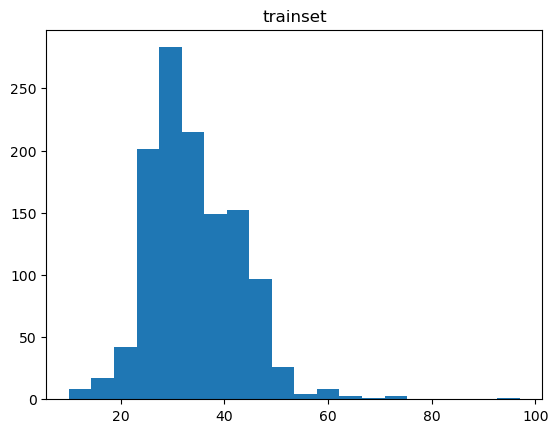

min/max : 10 97


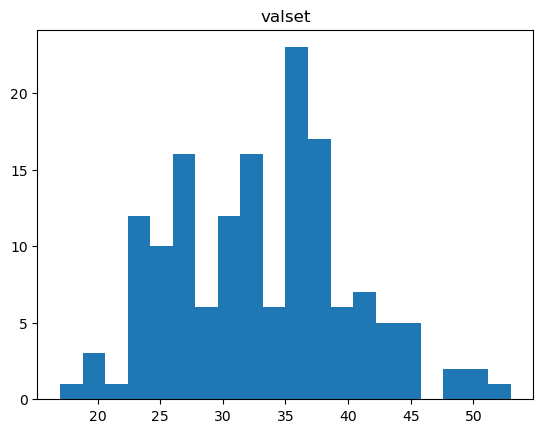

min/max : 17 53


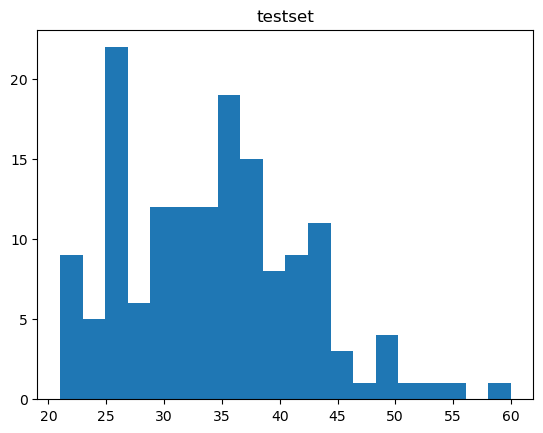

min/max : 21 60


In [6]:
def plot_histo_graphs(dataset, title):
    # histogram of graph sizes
    graph_sizes = []
    for graph in dataset:
        graph_sizes.append(graph[0].number_of_nodes())
    plt.figure(1)
    plt.hist(graph_sizes, bins=20)
    plt.title(title)
    plt.show()
    graph_sizes = torch.Tensor(graph_sizes)
    print('min/max :',graph_sizes.min().long().item(),graph_sizes.max().long().item())
    
plot_histo_graphs(dataset.train,'trainset')
plot_histo_graphs(dataset.val,'valset')
plot_histo_graphs(dataset.test,'testset')

In [7]:
print(len(dataset.train))
print(len(dataset.val))
print(len(dataset.test))

print(dataset.train[0])
print(dataset.val[0])
print(dataset.test[0])

print(dataset.train[0][0].ndata['atom_type'])

print(dataset.train.graph_labels)
print(dataset.val.graph_labels)
print(dataset.test.graph_labels)

print(sum(1 for label in dataset.train.graph_labels if label == 1))
print(sum(1 for label in dataset.val.graph_labels if label == 1))
print(sum(1 for label in dataset.test.graph_labels if label == 1))

1210
151
152
(Graph(num_nodes=31, num_edges=66,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32), 'atom_type': Scheme(shape=(), dtype=torch.int32)}
      edata_schemes={'feat': Scheme(shape=(12,), dtype=torch.float32)}), 1)
(Graph(num_nodes=36, num_edges=78,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32), 'atom_type': Scheme(shape=(), dtype=torch.int32)}
      edata_schemes={'feat': Scheme(shape=(12,), dtype=torch.float32)}), 0)
(Graph(num_nodes=35, num_edges=76,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32), 'atom_type': Scheme(shape=(), dtype=torch.int32)}
      edata_schemes={'feat': Scheme(shape=(12,), dtype=torch.float32)}), 0)
tensor([ 4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  1, 54,  1, 54, 54,
         1,  1, 53,  1,  1,  1,  1, 53,  1,  4,  4,  1,  1], dtype=torch.int32)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0

In [8]:
start = time.time()
with open('/home/zsy123/benchmarking-gnns-master/data/molecules/BACE/bace_8-1-1.pkl','wb') as f:
        pickle.dump([dataset.train,dataset.val,dataset.test,num_atom_type,num_bond_type],f)
print('Time (sec):',time.time() - start)

Time (sec): 0.6088900566101074


# Test load function

In [11]:
DATASET_NAME = 'BACE'
dataset = LoadData(DATASET_NAME,1)
trainset, valset, testset = dataset.train, dataset.val, dataset.test

[I] 加载数据集 BACE...
[I] 正在加载数据集 BACE...
[I] 数据集 BACE 加载成功
训练集大小: 906, 测试集大小: 302, 验证集大小: 302
[I] 数据加载完成，耗时: 0.8868s
[I] 成功加载数据集: BACE


In [37]:
batch_size = 10
collate = MoleculeDataset.collate
print(MoleculeDataset)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)

<class 'data.molecules.MoleculeDataset'>
